##Задача классификации

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gkalpolukcu/knn-algorithm-dataset")

print("Path to dataset files:", path)

100%|██████████| 48.7k/48.7k [00:00<00:00, 32.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/gkalpolukcu/knn-algorithm-dataset/versions/1


Accuracy: 0.972027972027972


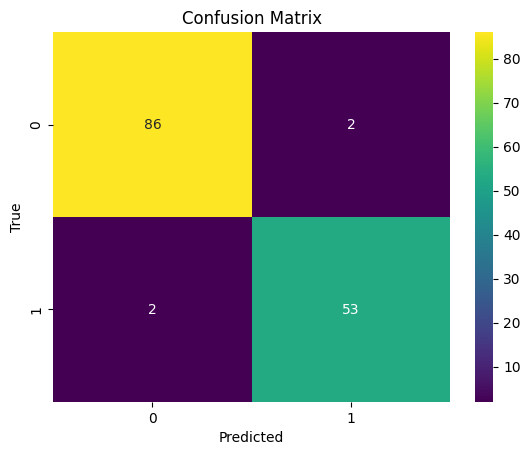

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        88
           1       0.96      0.96      0.96        55

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143

ROC AUC Score: 0.9979338842975206


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/root/.cache/kagglehub/datasets/gkalpolukcu/knn-algorithm-dataset/versions/1/KNNAlgorithmDataset.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)

data['diagnosis'] = data['diagnosis'].map({'B': 0, 'M': 1})

X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1])
print(f'ROC AUC Score: {roc_auc}')


###Улучшенный бейзлайн

Для улучшения бейзлайна сбалансируем класс с помощью SMOTE для улучшения точности на несбалансированных данных, используем GridSearchCV для подбора гиперпараметров модели, добавим расчет F1-метрики для более точной оценки модели при несбалансированных классах

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.972027972027972
F1 Score: 0.9649122807017544
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        88
           1       0.93      1.00      0.96        55

    accuracy                           0.97       143
   macro avg       0.97      0.98      0.97       143
weighted avg       0.97      0.97      0.97       143

ROC AUC Score: 0.9971074380165289


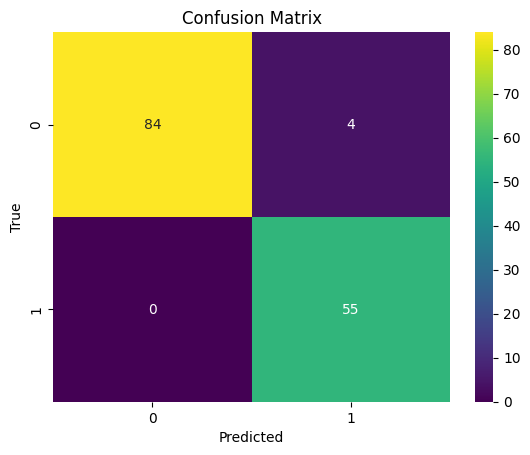

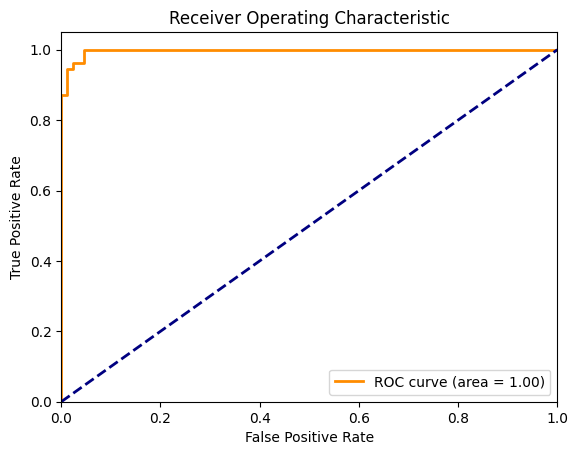

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

data = pd.read_csv('/root/.cache/kagglehub/datasets/gkalpolukcu/knn-algorithm-dataset/versions/1/KNNAlgorithmDataset.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)

data['diagnosis'] = data['diagnosis'].map({'B': 0, 'M': 1})

X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X_train_res, y_train_res)

print(f"Best parameters: {grid_search.best_params_}")
rf = grid_search.best_estimator_

rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1])
print(f'ROC AUC Score: {roc_auc}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test_scaled)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Результат очень незначительно ухудшился, но он уже был достаточно хорошим, поэтому добиться заметных улучшений сложно.

##Задача регрессии

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/netflix-imdb-scores")

print("Path to dataset files:", path)

100%|██████████| 699k/699k [00:00<00:00, 64.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/netflix-imdb-scores/versions/2


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv('/root/.cache/kagglehub/datasets/thedevastator/netflix-imdb-scores/versions/2/Netflix TV Shows and Movies.csv')

data['imdb_votes'] = data['imdb_votes'].fillna(data['imdb_votes'].mean())
data['age_certification'] = data['age_certification'].fillna(data['age_certification'].mode()[0])

X = data[['release_year', 'runtime', 'imdb_votes']]
y = data['imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')


Mean Squared Error: 1.1200654441434061
Mean Absolute Error: 0.7863325807563906
R² Score: 0.2134103039988251


###Улучшенный бейзлайн

В качестве улучшения были добавлены признаки, использовался KNNImputer для улучшения заполнения пропусков в столбце imdb_votes, GridSearchCV для поиска оптимальных гиперпараметров модели случайного леса и были увеличены возможные значения параметров, таких как n_estimators, max_depth, min_samples_split, min_samples_leaf.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer

data = pd.read_csv('/root/.cache/kagglehub/datasets/thedevastator/netflix-imdb-scores/versions/2/Netflix TV Shows and Movies.csv')

imputer = KNNImputer(n_neighbors=5)
data[['imdb_votes']] = imputer.fit_transform(data[['imdb_votes']])

data['age_certification'] = data['age_certification'].fillna(data['age_certification'].mode()[0])

X = data[['release_year', 'runtime', 'imdb_votes', 'type', 'age_certification']]
y = data['imdb_score']
X_encoded = pd.get_dummies(X, columns=['type', 'age_certification'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')


Mean Squared Error: 1.0610461237725044
Mean Absolute Error: 0.7557753827490084
R² Score: 0.25485787254179293


Результат заметно улучшился, особенно по сравнению с другими алгоритмами

##Самостоятельно имплементированные модели

Accuracy: 0.965034965034965


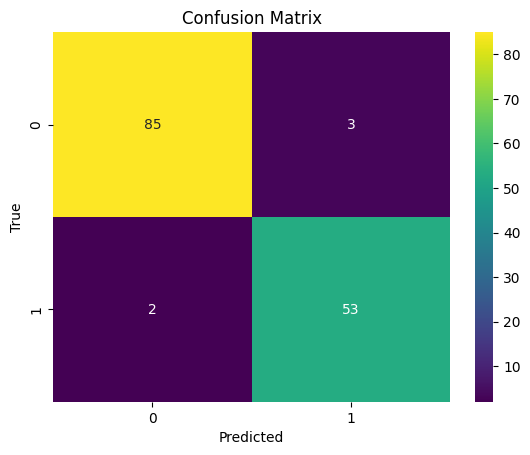

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        88
           1       0.95      0.96      0.95        55

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143

ROC AUC Score: 0.9647727272727272


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/root/.cache/kagglehub/datasets/gkalpolukcu/knn-algorithm-dataset/versions/1/KNNAlgorithmDataset.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)

data['diagnosis'] = data['diagnosis'].map({'B': 0, 'M': 1})

X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        if len(unique_classes) == 1 or (self.max_depth and depth == self.max_depth) or n_samples < self.min_samples_split:
            return unique_classes[0]

        if self.max_features:
            features = np.random.choice(n_features, self.max_features, replace=False)
        else:
            features = range(n_features)

        best_gini = float('inf')
        best_split = None
        best_left_y, best_right_y = None, None
        best_left_X, best_right_X = None, None

        for feature in features:
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                left_y = y[left_mask]
                right_y = y[right_mask]

                left_X = X[left_mask]
                right_X = X[right_mask]

                if len(left_y) < self.min_samples_split or len(right_y) < self.min_samples_split:
                    continue

                gini = self._gini_impurity(left_y, right_y)
                if gini < best_gini:
                    best_gini = gini
                    best_split = (feature, threshold)
                    best_left_y, best_right_y = left_y, right_y
                    best_left_X, best_right_X = left_X, right_X

        if best_split is None:
            return np.random.choice(unique_classes)

        left_tree = self._build_tree(best_left_X, best_left_y, depth + 1)
        right_tree = self._build_tree(best_right_X, best_right_y, depth + 1)

        return {'feature': best_split[0], 'threshold': best_split[1], 'left': left_tree, 'right': right_tree}

    def _gini_impurity(self, left_y, right_y):
        left_size, right_size = len(left_y), len(right_y)
        total_size = left_size + right_size

        left_prob = np.sum(left_y == 1) / left_size if left_size > 0 else 0
        right_prob = np.sum(right_y == 1) / right_size if right_size > 0 else 0

        left_gini = 1 - left_prob**2 - (1 - left_prob)**2
        right_gini = 1 - right_prob**2 - (1 - right_prob)**2

        return (left_size / total_size) * left_gini + (right_size / total_size) * right_gini

    def predict(self, X):
        return [self._predict_sample(sample, self.tree) for sample in X]

    def _predict_sample(self, sample, tree):
        if isinstance(tree, dict):
            if sample[tree['feature']] <= tree['threshold']:
                return self._predict_sample(sample, tree['left'])
            else:
                return self._predict_sample(sample, tree['right'])
        else:
            return tree

class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]

        if isinstance(self.max_features, str) and self.max_features == 'sqrt':
            self.max_features = int(np.sqrt(X.shape[1]))

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]

            tree = DecisionTree(self.max_depth, self.min_samples_split, self.max_features)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        X = np.array(X)
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return [np.bincount(prediction).argmax() for prediction in predictions.T]

rf = RandomForest(n_estimators=100, max_depth=10, max_features='sqrt')
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC Score: {roc_auc}')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/root/.cache/kagglehub/datasets/gkalpolukcu/knn-algorithm-dataset/versions/1/KNNAlgorithmDataset.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)

data['diagnosis'] = data['diagnosis'].map({'B': 0, 'M': 1})

X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

smote = SMOTE(k_neighbors=5, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

class OptimizedDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        if len(unique_classes) == 1 or (self.max_depth and depth == self.max_depth) or n_samples < self.min_samples_split:
            return unique_classes[0]

        if self.max_features:
            features = np.random.choice(n_features, self.max_features, replace=False)
        else:
            features = range(n_features)

        best_gini = float('inf')
        best_split = None
        best_left_y, best_right_y = None, None
        best_left_X, best_right_X = None, None

        for feature in features:
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                left_y = y[left_mask]
                right_y = y[right_mask]

                if len(left_y) < self.min_samples_split or len(right_y) < self.min_samples_split:
                    continue

                gini = self._gini_impurity(left_y, right_y)
                if gini < best_gini:
                    best_gini = gini
                    best_split = (feature, threshold)
                    best_left_y, best_right_y = left_y, right_y
                    best_left_X, best_right_X = X[left_mask], X[right_mask]

        if best_split is None:
            return np.random.choice(unique_classes)

        left_tree = self._build_tree(best_left_X, best_left_y, depth + 1)
        right_tree = self._build_tree(best_right_X, best_right_y, depth + 1)

        return {'feature': best_split[0], 'threshold': best_split[1], 'left': left_tree, 'right': right_tree}

    def _gini_impurity(self, left_y, right_y):
        left_size, right_size = len(left_y), len(right_y)
        total_size = left_size + right_size

        left_prob = np.sum(left_y == 1) / left_size if left_size > 0 else 0
        right_prob = np.sum(right_y == 1) / right_size if right_size > 0 else 0

        left_gini = 1 - left_prob**2 - (1 - left_prob)**2
        right_gini = 1 - right_prob**2 - (1 - right_prob)**2

        return (left_size / total_size) * left_gini + (right_size / total_size) * right_gini

    def predict(self, X):
        return [self._predict_sample(sample, self.tree) for sample in X]

    def _predict_sample(self, sample, tree):
        if isinstance(tree, dict):
            if sample[tree['feature']] <= tree['threshold']:
                return self._predict_sample(sample, tree['left'])
            else:
                return self._predict_sample(sample, tree['right'])
        else:
            return tree

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

    def get_params(self, deep=True):
        return {
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'max_features': self.max_features
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


class OptimizedRandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'max_features': self.max_features
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]

            tree = OptimizedDecisionTree(self.max_depth, self.min_samples_split, self.max_features)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return [np.bincount(prediction).argmax() for prediction in predictions.T]

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)


param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2', None]
}

rf = OptimizedRandomForest()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train_scaled, y_train_balanced)

print(f"Best parameters: {grid_search.best_params_}")

y_pred = grid_search.best_estimator_.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC Score: {roc_auc}')


Mean Squared Error: 1.1447822885774632
R^2 Score: 0.2142592762942691


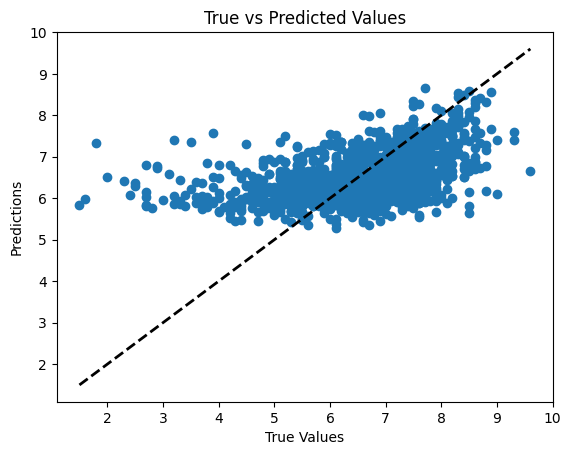

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/root/.cache/kagglehub/datasets/thedevastator/netflix-imdb-scores/versions/2/Netflix TV Shows and Movies.csv')

data['imdb_votes'] = data['imdb_votes'].fillna(data['imdb_votes'].mean())
data['age_certification'] = data['age_certification'].fillna(data['age_certification'].mode()[0])

X = data[['release_year', 'runtime', 'imdb_votes']]
y = data['imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape

        if len(set(y)) == 1 or (self.max_depth is not None and depth == self.max_depth) or n_samples < self.min_samples_split:
            return np.mean(y)

        best_mse = float('inf')
        best_split = None
        best_left_y, best_right_y = None, None
        best_left_X, best_right_X = None, None

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                left_y = y[left_mask]
                right_y = y[right_mask]

                if len(left_y) < self.min_samples_split or len(right_y) < self.min_samples_split:
                    continue

                mse = self._mean_squared_error(left_y, right_y)
                if mse < best_mse:
                    best_mse = mse
                    best_split = (feature, threshold)
                    best_left_y, best_right_y = left_y, right_y
                    best_left_X, best_right_X = X[left_mask], X[right_mask]

        if best_split is None:
            return np.mean(y)

        left_tree = self._build_tree(best_left_X, best_left_y, depth + 1)
        right_tree = self._build_tree(best_right_X, best_right_y, depth + 1)

        return {'feature': best_split[0], 'threshold': best_split[1], 'left': left_tree, 'right': right_tree}

    def _mean_squared_error(self, left_y, right_y):
        left_mse = np.mean((left_y - np.mean(left_y)) ** 2) if len(left_y) > 0 else 0
        right_mse = np.mean((right_y - np.mean(right_y)) ** 2) if len(right_y) > 0 else 0
        return left_mse * (len(left_y) / (len(left_y) + len(right_y))) + right_mse * (len(right_y) / (len(left_y) + len(right_y)))

    def predict(self, X):
        return [self._predict_sample(sample, self.tree) for sample in X]

    def _predict_sample(self, sample, tree):
        if isinstance(tree, dict):
            if sample[tree['feature']] <= tree['threshold']:
                return self._predict_sample(sample, tree['left'])
            else:
                return self._predict_sample(sample, tree['right'])
        else:
            return tree

class RandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y.iloc[indices]

            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5)
rf_regressor.fit(X_train_scaled, y_train)

y_pred = rf_regressor.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()


Mean Squared Error: 1.0939627099403335
R^2 Score: 0.24914015530085976


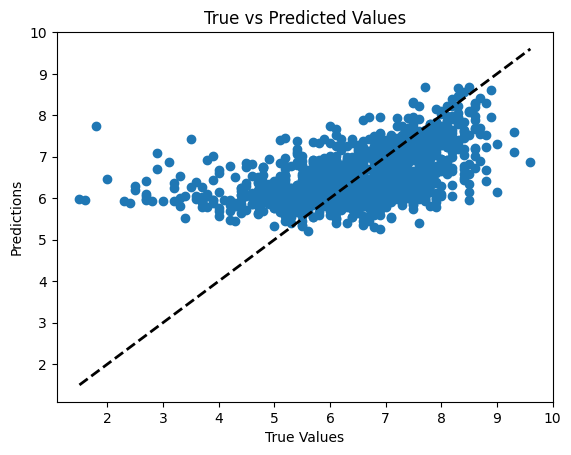

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/root/.cache/kagglehub/datasets/thedevastator/netflix-imdb-scores/versions/2/Netflix TV Shows and Movies.csv')

data['imdb_votes'] = data['imdb_votes'].fillna(data['imdb_votes'].mean())
data['age_certification'] = data['age_certification'].fillna(data['age_certification'].mode()[0])

X = data[['release_year', 'runtime', 'imdb_votes', 'type', 'age_certification']]
y = data['imdb_score']

X_encoded = pd.get_dummies(X, columns=['type', 'age_certification'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=101)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape

        if len(set(y)) == 1 or (self.max_depth is not None and depth == self.max_depth) or n_samples < self.min_samples_split:
            return np.mean(y)

        best_mse = float('inf')
        best_split = None
        best_left_y, best_right_y = None, None
        best_left_X, best_right_X = None, None

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                left_y = y[left_mask]
                right_y = y[right_mask]

                if len(left_y) < self.min_samples_split or len(right_y) < self.min_samples_split:
                    continue

                mse = self._mean_squared_error(left_y, right_y)
                if mse < best_mse:
                    best_mse = mse
                    best_split = (feature, threshold)
                    best_left_y, best_right_y = left_y, right_y
                    best_left_X, best_right_X = X[left_mask], X[right_mask]

        if best_split is None:
            return np.mean(y)

        left_tree = self._build_tree(best_left_X, best_left_y, depth + 1)
        right_tree = self._build_tree(best_right_X, best_right_y, depth + 1)

        return {'feature': best_split[0], 'threshold': best_split[1], 'left': left_tree, 'right': right_tree}

    def _mean_squared_error(self, left_y, right_y):
        left_mse = np.mean((left_y - np.mean(left_y)) ** 2) if len(left_y) > 0 else 0
        right_mse = np.mean((right_y - np.mean(right_y)) ** 2) if len(right_y) > 0 else 0
        return left_mse * (len(left_y) / (len(left_y) + len(right_y))) + right_mse * (len(right_y) / (len(left_y) + len(right_y)))

    def predict(self, X):
        return [self._predict_sample(sample, self.tree) for sample in X]

    def _predict_sample(self, sample, tree):
        if isinstance(tree, dict):
            if sample[tree['feature']] <= tree['threshold']:
                return self._predict_sample(sample, tree['left'])
            else:
                return self._predict_sample(sample, tree['right'])
        else:
            return tree

class RandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y.iloc[indices]

            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5)
rf_regressor.fit(X_train_scaled, y_train)

y_pred = rf_regressor.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()
